# Data acquisition/processing and kernel calculation demo using SPECFEM3D_GLOBE

Authors:
- Ayon Gosh,
- Masaru Nagaso
- Ridvan Örsvuran,
- Ebru Bozdağ,

All authors are affiliated with Colorado School of Mines.

## How to calculate a clean banana-donut kernel

This notebook demonstrates how to:
- acquire the observed seismic data, 
- process it (filtering, resampling, removing instrument response, etc.), and
- perform kernel calculation using the SPECFEM3D_GLOBE.

The libraries listed below are required to run this notebook. This notebook is intended to be run on Frontera at TACC as the SPECFEM3D_GLOBE requires a large amount of computational resources.
However it is also possible to run it on the other machines if it has enough computational resources.

- General python libraries: numpy, matplotlib, cartopy
- [Obspy](https://docs.obspy.org/): for seismic data acquisition and processing
- [Containerized SPECFEM3D_GLOBE](https://github.com/SeisSCOPED/specfem3d_globe/pkgs/container/specfem3d_globe): for synthetic data generation and kernel calculation


In [1]:
import numpy as np
np.float_ = np.float64
from prophet import Prophet

# import necessary modules (this may take 1 minute on Frontera)
%matplotlib inline

import obspy
from obspy.clients.fdsn.mass_downloader import GlobalDomain
from obspy.clients.fdsn.mass_downloader import MassDownloader
from obspy.clients.fdsn.mass_downloader import Restrictions
from obspy.geodetics import locations2degrees
from obspy.signal.invsim import cosine_sac_taper
from obspy.signal.util import _npts2nfft
from obspy.imaging.beachball import beach
from obspy.taup import TauPyModel
import obspy.geodetics

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from scipy.integrate import simpson

import os

from ipywidgets import *

cwd = os.getcwd()

disp_unit = 'mm'

# use interactive plotting for adjoint source calculation
interactive = False

Importing plotly failed. Interactive plots will not work.


## Downloading Event Information and 1D/3D synthetic data

In this example, we use Global Centroid Moment Tensor (CMT) solution for the 2024 Noto Peninsula earthquake, which can be downloaded from [The Harvard Centroid Moment Tensor Catalog Web Page](https://www.globalcmt.org/CMTsearch.html).  

### CMTSOLUTION file

Here is the [CMTSOLUTION](./simulation/DATA/CMTSOLUTION) file for the 2024 Noto Peninsula earthquake:

``` yaml
 PDEQ2024  1  1  7 10  9.70  37.5000  137.2400  10.0 0.0 7.5 NEAR WEST COAST OF HONSH
event name:     202401010710A
time shift:     29.4400
half duration:  14.2000
latitude:       37.4900
longitude:     137.1700
depth:          12.0000
Mrr:       2.260000e+27
Mtt:      -7.540000e+26
Mpp:      -1.510000e+27
Mrt:      -2.870000e+26
Mrp:      -6.060000e+26
Mtp:      -1.310000e+27
```

We can also download the 1D/3D synthetic data for this event from the [Global Shake Movie of Princeton University](https://global.shakemovie.princeton.edu/event.jsp?evid=C202401010710A&mode=scientific)



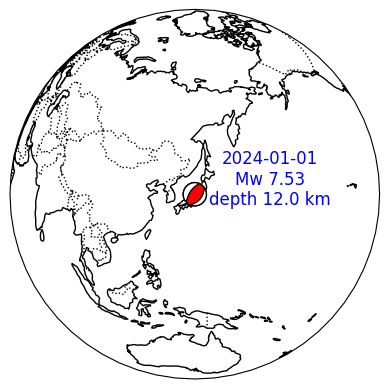

In [2]:
# event name
eqname = "C202401010710A"
# file path to the downloaded event
cmt_filename = "CMTs/{}".format(eqname)
# read the event
cat = obspy.read_events(cmt_filename)

# plot
ortho = ccrs.Orthographic(central_longitude=cat[0].origins[0].longitude, central_latitude=cat[0].origins[0].latitude)
geo = ccrs.Geodetic()
ax = plt.axes(projection=ortho)

# plot coastlines and borders
ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_global()

# event position
xy = [cat[0].origins[0].longitude, cat[0].origins[0].latitude]
# transform to map coordinates
xy = geo.transform_point(xy[0], xy[1], src_crs=geo)
# plot focal mechanism
_mt = cat[0].focal_mechanisms[0].moment_tensor.tensor
mt = [_mt.m_rr, _mt.m_tt, _mt.m_pp, _mt.m_rt, _mt.m_rp, _mt.m_tp]
bb = beach(mt, linewidth=1.0, xy=xy,  facecolor='red', edgecolor='black', width=800000)
ax.add_collection(bb)

# add text magnitude number, event name, datetime
plt.text(xy[0]*19000, xy[1]*14000,
         "{}\nMw {}\ndepth {} km".format(cat[0].origins[0].time.strftime("%Y-%m-%d"),
                                   cat[0].magnitudes[0].mag,
                                   cat[0].origins[0].depth/1000),
         fontsize=12, ha='center', va='center', color='blue')

plt.show()

## Downloading Observed Seismic Data

We can also download seismic recordings and instrumentation information using obspy.

In [3]:
# download waveform data from IRIS

def download_data(eqname, t0, min_length=180, stations="*"):
    domain = GlobalDomain()

    restrictions = Restrictions(
        # Get data for a whole year.
        starttime=t0,
        endtime=t0+60*min_length,
        # Chunk it to have one file per day.
        chunklength_in_sec=86400,
        # Considering the enormous amount of data associated with continuous
        # requests, you might want to limit the data based on SEED identifiers.
        # If the location code is specified, the location priority list is not
        # used; the same is true for the channel argument and priority list.
        network="*", station=stations, location="00", channel="BH*",
        # The typical use case for such a data set are noise correlations where
        # gaps are dealt with at a later stage.
        reject_channels_with_gaps=True,
        # Same is true with the minimum length. All data might be useful.
        minimum_length=0.0,
        # Guard against the same station having different names.
        minimum_interstation_distance_in_m=100.0)

    # create directories to store the data
    waveform_dir = "data/{}/waveforms".format(eqname)
    stationxml_dir = "data/{}/stations".format(eqname)
    os.makedirs(waveform_dir, exist_ok=True)
    os.makedirs(stationxml_dir, exist_ok=True)

    mdl = MassDownloader(providers=["IRIS"])
    mdl.download(domain, restrictions,
                 mseed_storage=waveform_dir,
                 stationxml_storage=stationxml_dir)


# target station names
stations = "BORK,TARA"

# get the origin time of the event|
event = cat[0]
origin = event.origins[0]

# download data (skipped if already downloaded)
download_data(eqname, origin.time-30, min_length=40, stations=stations)


[2025-04-04 13:22:13,404] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for IRIS.
[2025-04-04 13:22:14,388] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): IRIS.
[2025-04-04 13:22:14,391] - obspy.clients.fdsn.mass_downloader - INFO: Total acquired or preexisting stations: 0
[2025-04-04 13:22:14,392] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Requesting reliable availability.
[2025-04-04 13:22:14,690] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Successfully requested availability (0.30 seconds)
[2025-04-04 13:22:14,692] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Found 2 stations (6 channels).
[2025-04-04 13:22:14,694] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Will attempt to download data from 2 stations.
[2025-04-04 13:22:14,695] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Status for 6 time intervals/channels before downloading: EXISTS
[

## Indicate the station information 

Station information files are downloaded with the waveform data in `data/station/*.xml`. We can use the `obspy` package to read the station information. `cartopy` is used to plot the stations and data.



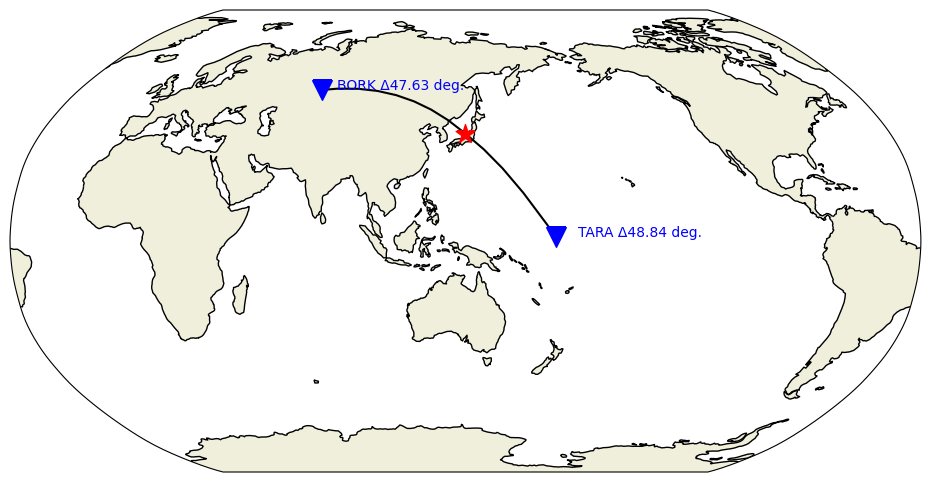

In [4]:
# plot stations on a map

# load the waveform data
obsd_filename_1 = "./data/C202401010710A/waveforms/II.BORK.00.BHZ*.mseed"
obsd_1 = obspy.read(obsd_filename_1)[0]
obsd_filename_2 = "./data/C202401010710A/waveforms/IU.TARA.00.BHZ*.mseed"
obsd_2 = obspy.read(obsd_filename_2)[0]

# load the station information
inv_1 = obspy.read_inventory("./data/C202401010710A/stations/II.BORK.xml")
sta_coord_1 = inv_1.get_coordinates(obsd_1.id)
inv_2 = obspy.read_inventory("./data/C202401010710A/stations/IU.TARA.xml")
sta_coord_2 = inv_2.get_coordinates(obsd_2.id)

fig, ax = plt.subplots(figsize=(12, 6), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=origin.longitude)))
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND)

# epicentral distance
dist_bork = locations2degrees(origin.latitude, origin.longitude, sta_coord_1["latitude"], sta_coord_1["longitude"])
dist_tara = locations2degrees(origin.latitude, origin.longitude, sta_coord_2["latitude"], sta_coord_2["longitude"])

ax.scatter(origin.longitude, origin.latitude, 200, marker="*", color="red", transform=ccrs.PlateCarree(), zorder=100)
ax.scatter(sta_coord_1["longitude"], sta_coord_1["latitude"], 200, marker="v", color="blue", transform=ccrs.PlateCarree(), zorder=100)
ax.text(sta_coord_1["longitude"]*1.1, sta_coord_1["latitude"], f"BORK Δ{dist_bork:5.2f} deg.", color="blue", transform=ccrs.PlateCarree(), zorder=100)
ax.scatter(sta_coord_2["longitude"], sta_coord_2["latitude"], 200, marker="v", color="blue", transform=ccrs.PlateCarree(), zorder=100)
ax.text(sta_coord_2["longitude"]*1.05, sta_coord_2["latitude"], f"TARA Δ{dist_tara:5.2f} deg.", color="blue", transform=ccrs.PlateCarree(), zorder=100)

ax.plot([origin.longitude, sta_coord_1["longitude"]], [origin.latitude, sta_coord_1["latitude"]], "k", transform=ccrs.Geodetic());
ax.plot([origin.longitude, sta_coord_2["longitude"]], [origin.latitude, sta_coord_2["latitude"]], "k", transform=ccrs.Geodetic());



## Forward Modeling using SPECFEM3D_GLOBE
<style>
r { color: Red }
o { color: Orange }
g { color: Green }
b { color: Blue }
bold { font-weight: bold }
</style>


### Initial file structure

The <bold>initial file structure</bold> of the simulation directory is as follows:

``` text
simulation
├─ DATA
|  ├─ CMTSOLUTION
|  ├─ STATIONS
|  └─ Par_file
| 
├─ DATABASES_MPI (empty)
├─ OUTPUT_FILES (empty)
```

### CMTSOLUTION file

As mentioned above.

### STATIONS file
[STATIONS](./simulation/DATA/STATIONS) file contains the station information which is used to calculate the synthetic seismograms.
Below is the STATIONS file used in this example:

``` text
BORK II 53.0461 70.3184 334.0 0.0 
TARA IU 1.3549 172.9229 18.0 0.0 
```
Each column represents:
Station, Network, Latitude(deg), Longitude(deg), Elevation(m), Burial(m)



### Par_file 
[Par_file](./simulation/DATA/Par_file) is the main parameter file for the SPECFEM3D_GLOBE simulation.

<pre style="height: 500px; width: 80%; overflow: scroll; ">

#-----------------------------------------------------------
#
# Simulation input parameters
#
#-----------------------------------------------------------

# forward or adjoint simulation
<r>SIMULATION_TYPE                 = 1</r>   # set to 1 for forward simulations, 2 for adjoint simulations for sources, and 3 for kernel simulations
NOISE_TOMOGRAPHY                = 0   # flag of noise tomography, three steps (1,2,3). If earthquake simulation, set it to 0.
<r>SAVE_FORWARD                    = .false.</r>   # save last frame of forward simulation or not

# number of chunks (1,2,3 or 6)
NCHUNKS                         = 1

# angular width of the first chunk (not used if full sphere with six chunks)
ANGULAR_WIDTH_XI_IN_DEGREES     = 90.d0   # angular size of a chunk
ANGULAR_WIDTH_ETA_IN_DEGREES    = 90.d0
CENTER_LATITUDE_IN_DEGREES      = 37.4881d0
CENTER_LONGITUDE_IN_DEGREES     = 137.1197d0
GAMMA_ROTATION_AZIMUTH          = 0.d0

# number of elements at the surface along the two sides of the first chunk
# (must be multiple of 16 and 8 * multiple of NPROC below)
<r>NEX_XI                          = 96</r>
<r>NEX_ETA                         = 96</r>

# number of MPI processors along the two sides of the first chunk
NPROC_XI                        = 6
NPROC_ETA                       = 6

#-----------------------------------------------------------
#
# Model
#
#-----------------------------------------------------------

# 1D models with real structure:
# 1D_isotropic_prem, 1D_transversely_isotropic_prem, 1D_iasp91, 1D_1066a, 1D_ak135f_no_mud, 1D_ref, 1D_ref_iso, 1D_jp3d,1D_sea99
#
# 1D models with only one fictitious averaged crustal layer:
# 1D_isotropic_prem_onecrust, 1D_transversely_isotropic_prem_onecrust, 1D_iasp91_onecrust, 1D_1066a_onecrust, 1D_ak135f_no_mud_onecrust
#
# fully 3D models:
# transversely_isotropic_prem_plus_3D_crust_2.0, 3D_anisotropic, 3D_attenuation,
# s20rts, s40rts, s362ani, s362iso, s362wmani, s362ani_prem, s362ani_3DQ, s362iso_3DQ,
# s29ea, sea99_jp3d1994, sea99, jp3d1994, heterogen, full_sh, sgloberani_aniso, sgloberani_iso
#
# 3D crustal models:
# crust1.0, crust2.0, EPcrust, EuCRUST, crustmaps, crustSH
#
# Mars models:
# 1D_Sohl, 1D_Sohl_3D_crust, 1D_case65TAY, 1D_case65TAY_3D_crust, mars_1D, mars_1D_3D_crust
#
# Moon models:
# vpremoon
#
# 3D models with 3D crust: append "_**crustname**" to the mantle model name
#                          to take a 3D crustal model (by default crust2.0 is taken for 3D mantle models)
#                          e.g. s20rts_crust1.0, s362ani_crustmaps, full_sh_crustSH, sglobe_EPcrust, etc.
#
# 3D models with 1D crust: append "_1Dcrust" to the 3D model name
#                          to take the 1D crustal model from the
#                          associated reference model rather than the default 3D crustal model
#                          e.g. s20rts_1Dcrust, s362ani_1Dcrust, etc.
#
<r>MODEL                           = s40rts</r>

# parameters describing the Earth model
OCEANS                          = .true.
ELLIPTICITY                     = .true.
TOPOGRAPHY                      = .true.
GRAVITY                         = .true.
ROTATION                        = .true.
ATTENUATION                     = .true.

FULL_GRAVITY                    = .false.

# record length in minutes
<r>RECORD_LENGTH_IN_MINUTES        = 25.5d0</r>

#-----------------------------------------------------------
#
# Mesh
#
#-----------------------------------------------------------

## regional mesh cut-off
# using this flag will cut-off the mesh in the mantle at a layer matching to the given cut-off depth.
# this flag only has an effect for regional simulations, i.e., for NCHUNKS values less than 6.
REGIONAL_MESH_CUTOFF            = .false.

# regional mesh cut-off depth (in km)
# possible selections are: 24.4d0, 80.d0, 220.d0, 400.d0, 600.d0, 670.d0, 771.d0
REGIONAL_MESH_CUTOFF_DEPTH      = 400.d0

# regional mesh cut-off w/ a second doubling layer below 220km interface
# (by default, a first doubling layer will be added below the Moho, and a second one below the 771km-depth layer.
#  Setting this flag to .true., will move the second one below the 220km-depth layer for regional mesh cut-offs only.)
REGIONAL_MESH_ADD_2ND_DOUBLING  = .false.

#-----------------------------------------------------------
#
# Absorbing boundary conditions
#
#-----------------------------------------------------------

# absorbing boundary conditions for a regional simulation
ABSORBING_CONDITIONS            = .true.

# run global simulation for a circular region and apply high attenuation for the rest of the model
# this creates an absorbing boundary with less reflection than stacey at a cost of 6x the computational cost
# NCHUNKS must be set to 6 to enable this flag
ABSORB_USING_GLOBAL_SPONGE      = .false.

# location and size of the region with no sponge (the region to run simulation)
SPONGE_LATITUDE_IN_DEGREES      = 40.d0
SPONGE_LONGITUDE_IN_DEGREES     = 25.d0
SPONGE_RADIUS_IN_DEGREES        = 25.d0

#-----------------------------------------------------------
#
# undoing attenuation for sensitivity kernel calculations
#
#-----------------------------------------------------------

# to undo attenuation for sensitivity kernel calculations or forward runs with SAVE_FORWARD
# use one (and only one) of the two flags below. UNDO_ATTENUATION is much better (it is exact)
# but requires a significant amount of disk space for temporary storage.
PARTIAL_PHYS_DISPERSION_ONLY    = .false.
<r>UNDO_ATTENUATION                = .true.</r>

## undo attenuation memory
# How much memory (in GB) is installed on your machine per CPU core
# (only used for UNDO_ATTENUATION, can be ignored otherwise)
# Beware, this value MUST be given per core, i.e. per MPI thread, i.e. per MPI rank, NOT per node.
# This value is for instance:
#   -  4 GB on Tiger at Princeton
#   -  4 GB on TGCC Curie in Paris
#   -  4 GB on Titan at ORNL when using CPUs only (no GPUs); start your run with "aprun -n$NPROC -N8 -S4 -j1"
#   -  2 GB on the machine used by Christina Morency
#   -  2 GB on the TACC machine used by Min Chen
#   -  1.5 GB on the GPU cluster in Marseille
# When running on GPU machines, it is simpler to set PERCENT_OF_MEM_TO_USE_PER_CORE = 100.d0
# and then set MEMORY_INSTALLED_PER_CORE_IN_GB to the amount of memory that you estimate is free (rather than installed)
# on the host of the GPU card while running your GPU job.
# For GPU runs on Titan at ORNL, use PERCENT_OF_MEM_TO_USE_PER_CORE = 100.d0 and MEMORY_INSTALLED_PER_CORE_IN_GB = 25.d0
# and run your job with "aprun -n$NPROC -N1 -S1 -j1"
# (each host has 32 GB on Titan, each GPU has 6 GB, thus even if all the GPU arrays are duplicated on the host
#  this leaves 32 - 6 = 26 GB free on the host; leaving 1 GB for the Linux system, we can safely use 100% of 25 GB)
MEMORY_INSTALLED_PER_CORE_IN_GB = 4.d0
# What percentage of this total do you allow us to use for arrays to undo attenuation, keeping in mind that you
# need to leave some memory available for the GNU/Linux system to run
# (a typical value is 85%; any value below is fine but the code will then save a lot of data to disk;
#  values above, say 90% or 92%, can be OK on some systems but can make the adjoint code run out of memory
#  on other systems, depending on how much memory per node the GNU/Linux system needs for itself; thus you can try
#  a higher value and if the adjoint crashes then try again with a lower value)
PERCENT_OF_MEM_TO_USE_PER_CORE  = 85.d0

## exact mass matrices for rotation
# three mass matrices instead of one are needed to handle rotation very accurately;
# otherwise rotation is handled slightly less accurately (but still reasonably well);
# set to .true. if you are interested in precise effects related to rotation;
# set to .false. if you are solving very large inverse problems at high frequency and also undoing attenuation exactly
#
# using the UNDO_ATTENUATION flag above, in which case saving as much memory as possible can be a good idea.
# You can also safely set it to .false. if you are not in a period range in which rotation matters,
# e.g. if you are targetting very short-period body waves. if in doubt, set to .true.
#
# You can safeely set it to .true. if you have ABSORBING_CONDITIONS above, because in that case the code
# will use three mass matrices anyway and thus there is no additional memory cost.
# this flag is of course unused if ROTATION above is set to .false.
EXACT_MASS_MATRIX_FOR_ROTATION  = .false.

#-----------------------------------------------------------
#
# LDDRK time scheme
#
#-----------------------------------------------------------

# this for LDDRK high-order time scheme instead of Newmark
USE_LDDRK                       = .false.

# the maximum CFL of LDDRK is significantly higher than that of the Newmark scheme,
# in a ratio that is theoretically 1.327 / 0.697 = 1.15 / 0.604 = 1.903 for a solid with Poisson's ratio = 0.25
# and for a fluid (see the manual of the 2D code, SPECFEM2D, Tables 4.1 and 4.2, and that ratio does not
# depend on whether we are in 2D or in 3D). However in practice a ratio of about 1.5 to 1.7 is often safer
# (for instance for models with a large range of Poisson's ratio values).
# Since the code computes the time step using the Newmark scheme, for LDDRK we will simply
# multiply that time step by this ratio when LDDRK is on and when flag INCREASE_CFL_FOR_LDDRK is true.
INCREASE_CFL_FOR_LDDRK          = .true.
RATIO_BY_WHICH_TO_INCREASE_IT   = 1.5d0

#-----------------------------------------------------------
#
# Visualization
#
#-----------------------------------------------------------

# save AVS or OpenDX movies
#MOVIE_COARSE saves movie only at corners of elements (SURFACE OR VOLUME)
#MOVIE_COARSE does not work with create_movie_AVS_DX
MOVIE_SURFACE                   = .false.
MOVIE_VOLUME                    = .false.
MOVIE_COARSE                    = .true.
NTSTEP_BETWEEN_FRAMES           = 50
HDUR_MOVIE                      = 0.d0

# save movie in volume.  Will save element if center of element is in prescribed volume
# top/bottom: depth in KM, use MOVIE_TOP = -100 to make sure the surface is stored.
# west/east: longitude, degrees East [-180/180] top/bottom: latitute, degrees North [-90/90]
# start/stop: frames will be stored at MOVIE_START + i*NSTEP_BETWEEN_FRAMES, where i=(0,1,2..) and iNSTEP_BETWEEN_FRAMES <= MOVIE_STOP
# movie_volume_type: 1=strain, 2=time integral of strain, 3=\mu*time integral of strain
# type 4 saves the trace and deviatoric stress in the whole volume, 5=displacement, 6=velocity
MOVIE_VOLUME_TYPE               = 2
MOVIE_TOP_KM                    = -100.0
MOVIE_BOTTOM_KM                 = 1000.0
MOVIE_WEST_DEG                  = -90.0
MOVIE_EAST_DEG                  = 90.0
MOVIE_NORTH_DEG                 = 90.0
MOVIE_SOUTH_DEG                 = -90.0
MOVIE_START                     = 0
MOVIE_STOP                      = 40000

# save mesh files to check the mesh
SAVE_MESH_FILES                 = .false.

# restart files (number of runs can be 1 or higher, choose 1 for no restart files)
NUMBER_OF_RUNS                  = 1
NUMBER_OF_THIS_RUN              = 1

# path to store the local database files on each node
LOCAL_PATH                      = ./DATABASES_MPI
# temporary wavefield/kernel/movie files
LOCAL_TMP_PATH                  = ./DATABASES_MPI

# interval at which we output time step info and max of norm of displacement
NTSTEP_BETWEEN_OUTPUT_INFO      = 500

#-----------------------------------------------------------
#
# Sources
#
#-----------------------------------------------------------

# use a (tilted) FORCESOLUTION force point source (or several) instead of a CMTSOLUTION moment-tensor source.
# This can be useful e.g. for asteroid simulations
# in which the source is a vertical force, normal force, tilted force, impact etc.
# If this flag is turned on, the FORCESOLUTION file must be edited by giving:
# - the corresponding time-shift parameter,
# - the half duration parameter of the source,
# - the coordinates of the source,
# - the source time function of the source,
# - the magnitude of the force source,
# - the components of a (non necessarily unitary) direction vector for the force source in the E/N/Z_UP basis.
# The direction vector is made unitary internally in the code and thus only its direction matters here;
# its norm is ignored and the norm of the force used is the factor force source times the source time function.
USE_FORCE_POINT_SOURCE          = .false.

# use monochromatic source time function for CMTSOLUTION moment-tensor source.
# half duration is interpreted as a PERIOD just to avoid changing CMTSOLUTION file format
# default is .false. which uses Heaviside function
USE_MONOCHROMATIC_CMT_SOURCE    = .false.

# print source time function
PRINT_SOURCE_TIME_FUNCTION      = .false.

#-----------------------------------------------------------
#
# Seismograms
#
#-----------------------------------------------------------

# interval in time steps for temporary writing of seismograms
NTSTEP_BETWEEN_OUTPUT_SEISMOS   = 5000000

# set to n to reduce the sampling rate of output seismograms by a factor of n
# defaults to 1, which means no down-sampling
NTSTEP_BETWEEN_OUTPUT_SAMPLE    = 1

# option to save strain seismograms
# this option is useful for strain Green's tensor
# this feature is currently under development
SAVE_SEISMOGRAMS_STRAIN         = .false.

# save seismograms also when running the adjoint runs for an inverse problem
# (usually they are unused and not very meaningful, leave this off in almost all cases)
SAVE_SEISMOGRAMS_IN_ADJOINT_RUN = .false.

# output format for the seismograms (one can use either or all of the three formats)
OUTPUT_SEISMOS_ASCII_TEXT       = .false.
OUTPUT_SEISMOS_SAC_ALPHANUM     = .false.
OUTPUT_SEISMOS_SAC_BINARY       = .true.
OUTPUT_SEISMOS_ASDF             = .false.
OUTPUT_SEISMOS_3D_ARRAY         = .false.

# rotate seismograms to Radial-Transverse-Z or use default North-East-Z reference frame
ROTATE_SEISMOGRAMS_RT           = .false.

# decide if main process writes all the seismograms or if all processes do it in parallel
WRITE_SEISMOGRAMS_BY_MAIN       = .true.

# save all seismograms in one large combined file instead of one file per seismogram
# to avoid overloading shared non-local file systems such as LUSTRE or GPFS for instance
SAVE_ALL_SEISMOS_IN_ONE_FILE    = .false.
USE_BINARY_FOR_LARGE_FILE       = .false.

# flag to impose receivers at the surface or allow them to be buried
RECEIVERS_CAN_BE_BURIED         = .true.

#-----------------------------------------------------------
#
#  Adjoint kernel outputs
#
#-----------------------------------------------------------

# interval in time steps for reading adjoint traces
# 0 = read the whole adjoint sources at start time
NTSTEP_BETWEEN_READ_ADJSRC      = 0

# use ASDF format for reading the adjoint sources
READ_ADJSRC_ASDF                = .false.

# this parameter must be set to .true. to compute anisotropic kernels
# in crust and mantle (related to the 21 Cij in geographical coordinates)
# default is .false. to compute isotropic kernels (related to alpha and beta)
ANISOTROPIC_KL                  = .false.

# output only transverse isotropic kernels (alpha_v,alpha_h,beta_v,beta_h,eta,rho)
# rather than fully anisotropic kernels when ANISOTROPIC_KL above is set to .true.
# means to save radial anisotropic kernels, i.e., sensitivity kernels for beta_v, beta_h, etc.
SAVE_TRANSVERSE_KL_ONLY         = .false.

# output only the kernels used for the current azimuthally anisotropic inversions of surface waves,
# i.e., bulk_c, bulk_betav, bulk_betah, eta, Gc_prime, Gs_prime and rho
# (Gc' & Gs' which are the normalized Gc & Gs kernels by isotropic \rho\beta of the 1D reference model)
SAVE_AZIMUTHAL_ANISO_KL_ONLY    = .false.

# output approximate Hessian in crust mantle region.
# means to save the preconditioning for gradients, they are cross correlations between forward and adjoint accelerations.
APPROXIMATE_HESS_KL             = .true.

# forces transverse isotropy for all mantle elements
# (default is to use transverse isotropy only between crust and 220)
# means we allow radial anisotropy throughout the whole crust/mantle region
USE_FULL_TISO_MANTLE            = .false.

# output kernel mask to zero out source region
# to remove large values near the sources in the sensitivity kernels
SAVE_SOURCE_MASK                = .false.

# output kernels on a regular grid instead of on the GLL mesh points (a bit expensive)
SAVE_REGULAR_KL                 = .false.

# compute steady state kernels for source encoding
STEADY_STATE_KERNEL             = .false.
STEADY_STATE_LENGTH_IN_MINUTES  = 0.d0

#-----------------------------------------------------------

# Dimitri Komatitsch, July 2014, CNRS Marseille, France:
# added the ability to run several calculations (several earthquakes)
# in an embarrassingly-parallel fashion from within the same run;
# this can be useful when using a very large supercomputer to compute
# many earthquakes in a catalog, in which case it can be better from
# a batch job submission point of view to start fewer and much larger jobs,
# each of them computing several earthquakes in parallel.
# To turn that option on, set parameter NUMBER_OF_SIMULTANEOUS_RUNS to a value greater than 1.
# To implement that, we create NUMBER_OF_SIMULTANEOUS_RUNS MPI sub-communicators,
# each of them being labeled "my_local_mpi_comm_world", and we use them
# in all the routines in "src/shared/parallel.f90", except in MPI_ABORT() because in that case
# we need to kill the entire run.
# When that option is on, of course the number of processor cores used to start
# the code in the batch system must be a multiple of NUMBER_OF_SIMULTANEOUS_RUNS,
# all the individual runs must use the same number of processor cores,
# which as usual is NPROC in the Par_file,
# and thus the total number of processor cores to request from the batch system
# should be NUMBER_OF_SIMULTANEOUS_RUNS * NPROC.
# All the runs to perform must be placed in directories called run0001, run0002, run0003 and so on
# (with exactly four digits).
#
# Imagine you have 10 independent calculations to do, each of them on 100 cores; you have three options:
#
# 1/ submit 10 jobs to the batch system
#
# 2/ submit a single job on 1000 cores to the batch, and in that script create a sub-array of jobs to start 10 jobs,
# each running on 100 cores (see e.g. http://www.schedmd.com/slurmdocs/job_array.html )
#
# 3/ submit a single job on 1000 cores to the batch, start SPECFEM3D on 1000 cores, create 10 sub-communicators,
# cd into one of 10 subdirectories (called e.g. run0001, run0002,... run0010) depending on the sub-communicator
# your MPI rank belongs to, and run normally on 100 cores using that sub-communicator.
#
# The option below implements 3/.
#
NUMBER_OF_SIMULTANEOUS_RUNS     = 1

# if we perform simultaneous runs in parallel, if only the source and receivers vary between these runs
# but not the mesh nor the model (velocity and density) then we can also read the mesh and model files
# from a single run in the beginning and broadcast them to all the others; for a large number of simultaneous
# runs for instance when solving inverse problems iteratively this can DRASTICALLY reduce I/Os to disk in the solver
# (by a factor equal to NUMBER_OF_SIMULTANEOUS_RUNS), and reducing I/Os is crucial in the case of huge runs.
# Thus, always set this option to .true. if the mesh and the model are the same for all simultaneous runs.
# In that case there is no need to duplicate the mesh and model file database (the content of the DATABASES_MPI
# directories) in each of the run0001, run0002,... directories, it is sufficient to have one in run0001
# and the code will broadcast it to the others)
BROADCAST_SAME_MESH_AND_MODEL   = .true.

#-----------------------------------------------------------

# set to true to use GPUs
GPU_MODE                        = .false.
# Only used if GPU_MODE = .true. :
GPU_RUNTIME                     = 1
# 2 (OpenCL), 1 (Cuda) ou 0 (Compile-time -- does not work if configured with --with-cuda *AND* --with-opencl)
GPU_PLATFORM                    = NVIDIA
GPU_DEVICE                      = Tesla

# set to true to use the ADIOS library for I/Os
ADIOS_ENABLED                   = .false.
ADIOS_FOR_FORWARD_ARRAYS        = .true.
ADIOS_FOR_MPI_ARRAYS            = .true.
ADIOS_FOR_ARRAYS_SOLVER         = .true.
ADIOS_FOR_SOLVER_MESHFILES      = .true.
ADIOS_FOR_AVS_DX                = .true.
ADIOS_FOR_KERNELS               = .true.
ADIOS_FOR_MODELS                = .true.
ADIOS_FOR_UNDO_ATTENUATION      = .true.

</pre>

We will be running our simulations with global S40RTS(Ritsema et al. 2011) model. 
    
### Verifying the run structure
Writing `CMTSOLUTION` with the obspy write utilities.\
Writing `STATIONS` file from the information.\
Making sure `DATABASES_MPI` and `OUTPUT_FILES` are present.

In [5]:
# prepare cmt solution (convert from quakeml to CMTSOLUTION)
event.write("./simulation/DATA/CMTSOLUTION", format="CMTSOLUTION")

# prepare STATIONS file for SPECFEM3D_GLOBE
# columns: station_name Network_name latitude longitude elevation burial
with open("./simulation/DATA/STATIONS", "w") as f:
    f.write(f'BORK II {sta_coord_1["latitude"]} {sta_coord_1["longitude"]} {sta_coord_1["elevation"]} {0.0} \n')
    f.write(f'TARA IU {sta_coord_2["latitude"]} {sta_coord_2["longitude"]} {sta_coord_2["elevation"]} {0.0} \n')

# create DATABASES_MPI and OUTPUT_FILES directories
os.makedirs("./simulation/DATABASES_MPI", exist_ok=True)
os.makedirs("./simulation/OUTPUT_FILES", exist_ok=True)

## Running the Simulation

We will not perform the wave propagation simulation on this notebook, instead we will load the precalculate data and perform the adjoint source calculation.

Below the command to run the simulation are kept but commented out for reference.


Binary files used, normally found in bin directory of the specfem3d_globe if you build it on your system. Here it's compiled in the docker image.

In [6]:
SPECDIR = "~/workspace/MINES/specfem3d_globe"
!ls {SPECDIR}/bin

xaddition_sem		       xcreate_cross_section
xadd_model_iso		       xcreate_header_file
xadd_model_tiso		       xcreate_movie_AVS_DX
xadd_model_tiso_cg	       xcreate_movie_GMT_global
xadd_model_tiso_iso	       xdetect_duplicates_stations_file
xclip_sem		       xdifference_sem
xcombine_AVS_DX		       xextract_database
xcombine_paraview_strain_data  xgindex3D
xcombine_sem		       xinterpolate_model
xcombine_surf_data	       xmeshfem3D
xcombine_surf_data_vtk	       xsmooth_laplacian_sem
xcombine_surf_data_vtu	       xsmooth_sem
xcombine_vol_data	       xspecfem3D
xcombine_vol_data_vtk	       xsum_kernels
xcombine_vol_data_vtu	       xsum_preconditioned_kernels
xconvolve_source_timefunction  xwrite_profile



`xmeshfem3D`: Create Mesh files and save them in `DATABASES_MPI` directory. Output log written in `output_mesher.txt` in the `OUTPUT_FILES` directory. 

 `xspecfem3d`: Run the solver with the given `CMTSOLUTION`. Output log written in `output_solver.txt` in the
     `OUTPUT_FILES` directory.
     
### Running the Mesher

In [7]:
!echo {SPECDIR}

/home/mnagaso/workspace/MINES/specfem3d_globe


In [8]:
# Run the forward simulation with docker
# The default NPROC values are 4, which may take ~ 1.5 hours.
# If you have a powerful computer, you can increase the NPROC_XI and NPROC_ETA values below
# to reduce the simulation time.

%cd {cwd}

# change directory to the simulation directory
%cd ./simulation

# change the simulation length to 30 minutes (in DATA/Par_file)
!sed -i 's/RECORD_LENGTH_IN_MINUTES\s*=.*$/RECORD_LENGTH_IN_MINUTES = 30.0d0/' DATA/Par_file

# change the NPROC values (in DATA/Par_file) to use 4 processes
!sed -i 's/NPROC_XI\s*=.*$/NPROC_XI = 2/' DATA/Par_file
!sed -i 's/NPROC_ETA\s*=.*$/NPROC_ETA = 2/' DATA/Par_file

# copy the model files from the container to the host directory
!cp -r {SPECDIR}/DATA/{{crust2.0,s20rts,s40rts,topo_bathy}} DATA/

# change the simulation setup for a forward simulation
!{SPECDIR}/utils/change_simulation_type.pl -F

# run mesher
!echo "Running mesher"
!mpirun -np 4 {SPECDIR}/bin/xmeshfem3D

!head -n 10 ./OUTPUT_FILES/output_mesher.txt
!echo "....."
!echo
!sed -n 106p ./OUTPUT_FILES/output_mesher.txt
!sed -n 107p ./OUTPUT_FILES/output_mesher.txt
!echo "....."
!echo
!tail -n 10 ./OUTPUT_FILES/output_mesher.txt

/home/mnagaso/workspace/MINES/workshop_scoped_2024_specfem3d_globe
/home/mnagaso/workspace/MINES/workshop_scoped_2024_specfem3d_globe/simulation
Changed simulation_type to 1 and save_forward = .true. in Par_file 
Running mesher

 ****************************
 *** Specfem3D MPI Mesher ***
 ****************************

 Version: v8.1.0-261-gcb0a08c2


 Planet: Earth

.....

 Mesh resolution:
   DT =   0.14000000000000001     
.....

 using single precision for the calculations

 smallest and largest possible floating-point numbers are:    1.17549435E-38   3.40282347E+38


 Elapsed time for mesh generation and buffer creation in seconds =    65.8781967    
 Elapsed time for mesh generation and buffer creation in hh:mm:ss =    0 h 01 m 05 s

 End of mesh generation



This command will create the mesh files and save them in the `DATABASES_MPI` directory.

<img src="./img/mesh_up.png" alt="mesh image" width="600px">
<img src="./img/mesh.png" alt="mesh image" width="600px">

### Running the Solver


#### Status check of the running simulation

To check the status of the running simulation, we can use the following command:

``` bash
tail -n 20 OUTPUT_FILES/output_solver.txt
```

In [9]:
# run solver
%cd {cwd}/simulation

!echo "Running solver"
!mpirun -np 4 {SPECDIR}/bin/xspecfem3D

!head -n 20 ./OUTPUT_FILES/output_solver.txt
!echo ...
!echo ...
!tail -n 20 ./OUTPUT_FILES/output_solver.txt

# change directory back to the original directory
%cd ..

/home/mnagaso/workspace/MINES/workshop_scoped_2024_specfem3d_globe/simulation
Running solver

 ******************************
 **** Specfem3D MPI Solver ****
 ******************************

 Version: v8.1.0-261-gcb0a08c2


 Planet: Earth


 There are            4  MPI processes
 Processes are numbered from 0 to            3

 There are           96  elements along xi in each chunk
 There are           96  elements along eta in each chunk

 There are            2  slices along xi in each chunk
 There are            2  slices along eta in each chunk
 There is a total of            4  slices in each chunk
...
...
 Estimated remaining time in seconds =    0.00000000    
 Estimated remaining time in hh:mm:ss =      0 h 00 m 00 s
 Estimated total run time in seconds =    22.0456982    
 Estimated total run time in hh:mm:ss =      0 h 00 m 22 s
 We have done    100.000000     % of that

 Writing the seismograms
 Component: .sem 
 Total number of receivers saved is            2  out of       

### File structure after simulation

After the simulation, the file structure of the simulation directory is as follows:

``` text
simulation
├─ DATA
|  ├─ CMTSOLUTION
|  ├─ STATIONS
|  └─ Par_file
|
├─ DATABASES_MPI
|  ├─ (mesh files)
|  
├─ OUTPUT_FILES
|  ├─ {network_name}.{station_name}.{component}.sem.sac

```

## Comparing the data and synthetic data

In [10]:
# read and plot the raw data

# load the observed waveform data
st_obs = obspy.read("./data/C202401010710A/waveforms/*mseed") # in mseed format

# load the synthetic waveform data with 3D model (with SPECFEM3D_GLOBE)
# use the result from the forward simulation
#st_syn = obspy.read("./simulation/OUTPUT_FILES/*sac") # in sac format

# use the precalculated synthetics with 3D model
st_syn= obspy.read("./data/C202401010710A/waveforms_syn/*sac") # in sac format

# load the 1D synthetic waveform data (with normal mode summation)
st_syn_1d = obspy.read("./shakemov_syn/1d/*sac") # in sac format

In [11]:
# reference time (t=0) is CMT time
origin = cat[0].origins[0]
reftime = origin.time

print(f"Reference time: {reftime}")

Reference time: 2024-01-01T07:10:39.140000Z


## Cutting and Resampling

The downloaded singals are generally cut and resampled for those purposes,
- to reduce the size of the data
- to match the sampling rate and time window of the observed data to the synthetic data

The process for the second purpose is also often done after calculating the adjoint sources,
but in this example, we will do the both at the same time here.

In [12]:
print("Initial state of the observed and synthetic data")
print ("BORK")
for trace in (st_obs+st_syn+st_syn_1d).select(station="BORK", channel="*Z"):
    print(f"{trace.id} sampling rate: {trace.stats.sampling_rate:5.2f} start: {trace.stats.starttime} end: {trace.stats.endtime} npts: {trace.stats.npts}")

print ("TARA")
for trace in (st_obs+st_syn+st_syn_1d).select(station="TARA", channel="*Z"):
    print(f"{trace.id} sampling rate: {trace.stats.sampling_rate:5.2f} start: {trace.stats.starttime} end: {trace.stats.endtime} npts: {trace.stats.npts}")


Initial state of the observed and synthetic data
BORK
II.BORK.00.BHZ sampling rate: 40.00 start: 2024-01-01T07:10:09.144538Z end: 2024-01-01T07:50:09.119538Z npts: 96000
II.BORK.S3.MXZ sampling rate:  7.14 start: 2024-01-01T07:10:17.840001Z end: 2024-01-01T07:40:51.700019Z npts: 13100
II.BORK.S1.LXZ sampling rate:  0.50 start: 2024-01-01T07:10:39.100000Z end: 2024-01-01T10:30:37.100000Z npts: 6000
TARA
IU.TARA.00.BHZ sampling rate: 40.00 start: 2024-01-01T07:10:09.144539Z end: 2024-01-01T07:50:09.119539Z npts: 96000
IU.TARA.S3.MXZ sampling rate:  7.14 start: 2024-01-01T07:10:17.840001Z end: 2024-01-01T07:40:51.700019Z npts: 13100
IU.TARA.S1.LXZ sampling rate:  0.50 start: 2024-01-01T07:10:39.100000Z end: 2024-01-01T10:30:37.100000Z npts: 6000


The observed data is broadband and have higher sampling rate, we reduce the sampling rate of the observed data to match with calculated synthetics which is 7.14 Hz here.\
We also cut the seismograms in the overlapping time-window where both observed and synthetic data is available.

In [13]:
# adjust the time window and resample the data
sampling_rate = st_syn[0].stats.sampling_rate

start_bork = np.max([st_obs.select(station="BORK", channel="*Z")[0].stats.starttime,
                     st_syn.select(station="BORK", channel="*Z")[0].stats.starttime]) #+ 100
end_bork   = np.min([st_obs.select(station="BORK", channel="*Z")[0].stats.endtime,
                    st_syn.select(station="BORK", channel="*Z")[0].stats.endtime]) #- 50
npts_bork = st_syn.select(station="BORK", channel="*Z")[0].stats.npts

for trace in st_obs.select(station="BORK"):
    trace.interpolate(sampling_rate=sampling_rate, starttime=start_bork, npts=npts_bork)

# fix the time window for 1D synthetics only for comparison
st_syn_1d.select(station="BORK").trim(starttime=start_bork, endtime=end_bork, pad=False)

print("BORK after resampling")
for trace in (st_obs+st_syn+st_syn_1d).select(station="BORK", channel="*Z"):
    print(f"{trace.id} sampling rate: {trace.stats.sampling_rate:5.2f} start: {trace.stats.starttime} end: {trace.stats.endtime} npts: {trace.stats.npts}")

start_tara = np.max([st_obs.select(station="TARA", channel="*Z")[0].stats.starttime,
                     st_syn.select(station="TARA", channel="*Z")[0].stats.starttime])
end_tara   = np.min([st_obs.select(station="TARA", channel="*Z")[0].stats.endtime,
                     st_syn.select(station="TARA", channel="*Z")[0].stats.endtime])
npts_tara = st_syn.select(station="TARA", channel="*Z")[0].stats.npts

for trace in st_obs.select(station="TARA"):
    trace.interpolate(sampling_rate=sampling_rate, starttime=start_tara, npts=npts_tara)

# fix the time window for 1D synthetics only for comparison
st_syn_1d.select(station="tara").trim(starttime=start_tara, endtime=end_tara, pad=False)

print("TARA after resampling")
for trace in (st_obs+st_syn+st_syn_1d).select(station="TARA", channel="*Z"):
    print(f"{trace.id} sampling rate: {trace.stats.sampling_rate:5.2f} start: {trace.stats.starttime} end: {trace.stats.endtime} npts: {trace.stats.npts}")



BORK after resampling
II.BORK.00.BHZ sampling rate:  7.14 start: 2024-01-01T07:10:17.840001Z end: 2024-01-01T07:40:51.700019Z npts: 13100
II.BORK.S3.MXZ sampling rate:  7.14 start: 2024-01-01T07:10:17.840001Z end: 2024-01-01T07:40:51.700019Z npts: 13100
II.BORK.S1.LXZ sampling rate:  0.50 start: 2024-01-01T07:10:39.100000Z end: 2024-01-01T07:40:51.100000Z npts: 907
TARA after resampling
IU.TARA.00.BHZ sampling rate:  7.14 start: 2024-01-01T07:10:17.840001Z end: 2024-01-01T07:40:51.700019Z npts: 13100
IU.TARA.S3.MXZ sampling rate:  7.14 start: 2024-01-01T07:10:17.840001Z end: 2024-01-01T07:40:51.700019Z npts: 13100
IU.TARA.S1.LXZ sampling rate:  0.50 start: 2024-01-01T07:10:39.100000Z end: 2024-01-01T07:40:51.100000Z npts: 907


## Filtering and Removing Instrument Response

Seismograms are the result of the convolution(*) of various time series. 

### Observed data:

$$
d(t) = S(t) * g(t) * i(t)
$$
### Synthetic data:

$$
s(t) = S(t) * g(t)
$$

$d(t)$: Observed Seismogram \
$s(t)$: Synthetic Seismogram \
$S(t)$: Source-time Function\
$g(t)$: Response of Earth Structure (elastic+anelastic)\
$i(t)$: Instrument Response. 

In order to compare the data, we need to deconvolve the instrument response from observed data and filter both data to a comparable frequency range.

We downloaded *StationXML* files with the seismic data. These files contain information about stations like location and response function. We can use this information to remove the instrument response.

#### <font color=blue>We have kept the period band in between 50 and 100 seconds. You can try changing this in the first 2 lines. </font>
    
#### <font color=blue>Remember, the simulations are accurate only upto 47 seconds.</font>
####  <font color=blue>This is one of the parameters which directly controls the shape of the kernels/sensitivity to the misfit.</font> 

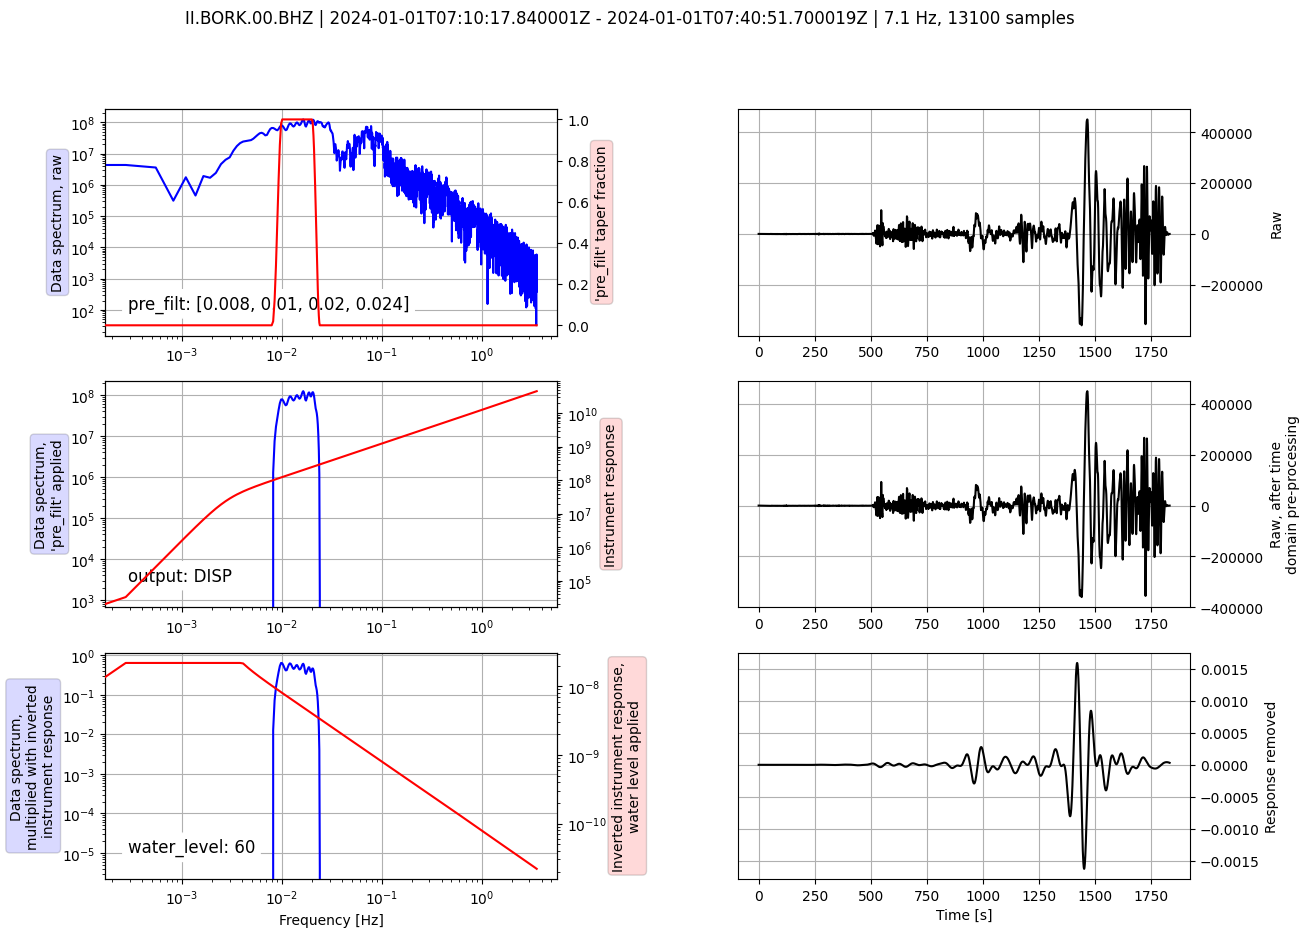

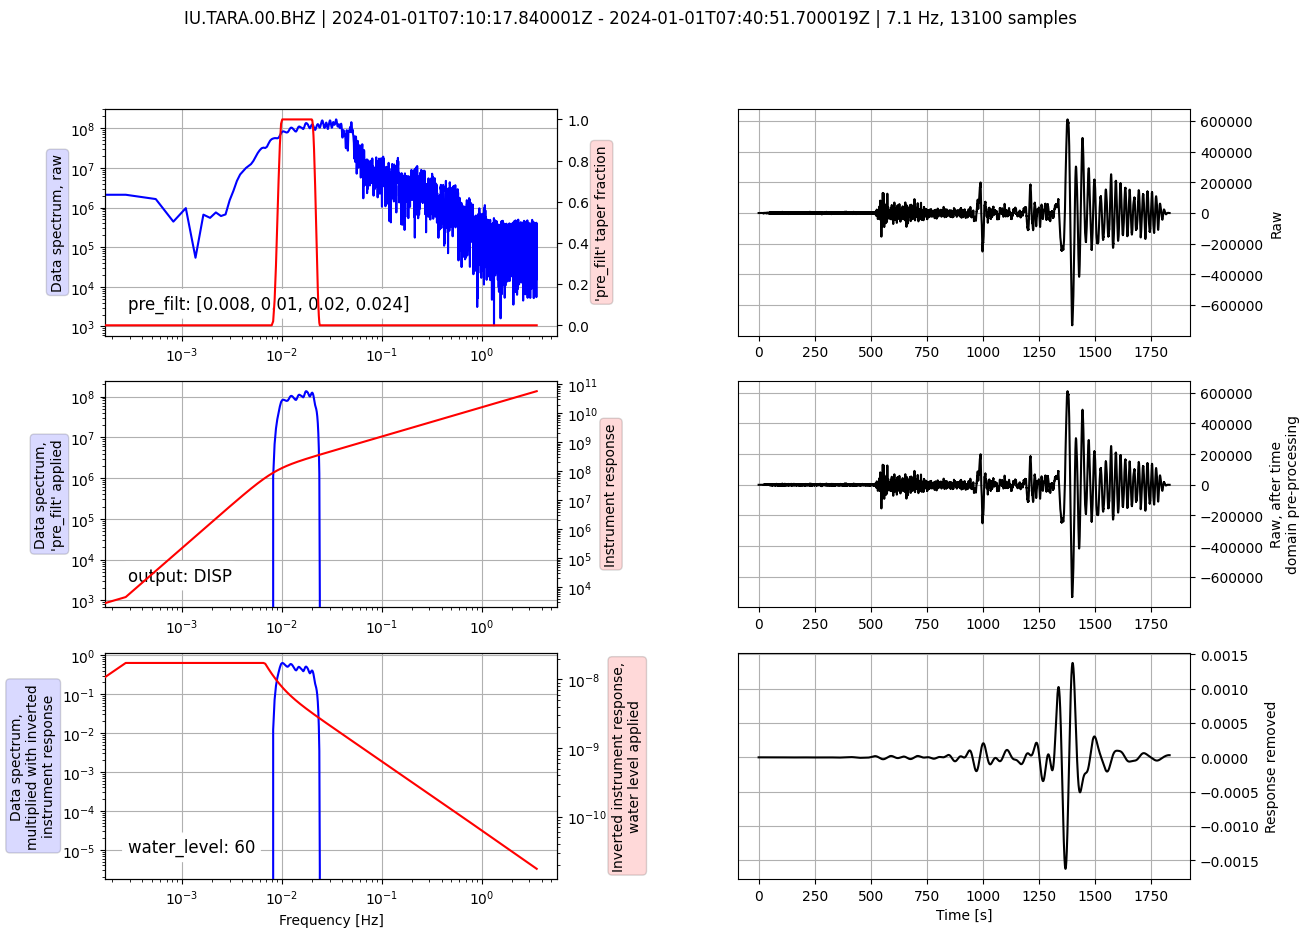

In [14]:
# frequency band for the bandpass filter
min_period = 50
max_period = 100
freqmin = 1.0/max_period
freqmax = 1.0/min_period
pre_filt = (0.8*freqmin, freqmin, freqmax, 1.2*freqmax)

# directory path to the instrument response files
dir_path_inv = f"./data/{eqname}/stations"

# process the observed data by each trace
for tr in st_obs:
    network = tr.stats.network
    station = tr.stats.station
    channel = tr.stats.channel
    # read the instrument response file
    inv = obspy.read_inventory(f"{dir_path_inv}/{network}.{station}.xml")
    # attach the instrument response to the trace
    tr.attach_response(inv)

    # add coordinates to the trace
    tr.stats.latitude = inv[0][0].latitude
    tr.stats.longitude = inv[0][0].longitude
    tr.stats.elevation = inv[0][0].elevation

    # change channel name from BH1 to BHN, BH2 to BHE (only for rotation with obspy)
    if tr.stats.channel == "BH1":
        tr.stats.channel = "BHN"
    elif tr.stats.channel == "BH2":
        tr.stats.channel = "BHE"

    # remove mean and linear trend
    tr.detrend("demean")
    tr.detrend("linear")
    # taper
    tr.taper(max_percentage=0.05, type="cosine")

    # plot the result if the trace is vertical
    if tr.stats.channel[-1] == "Z":
        plot = True
    else:
        plot = False

    # remove the instrument response with a pre-filter
    tr.remove_response(output="DISP", pre_filt=pre_filt, water_level=60, plot=plot)


In [15]:
# apply bandpass filter to the synthetic data

# use sac taper on synthetic data
def sac_taper(tr):
    data = tr.data.astype(np.float64)
    nfft = _npts2nfft(len(tr.data))
    data = np.fft.rfft(tr.data, nfft)
    fy = 1.0 / (tr.stats.delta * 2.0)
    freqs = np.linspace(0, fy, nfft//2+1)
    data *= cosine_sac_taper(freqs, flimit=pre_filt)
    data[-1] = abs(data[-1]) + 0.0j
    tr.data = np.fft.irfft(data)[0:len(tr.data)]

st_syn.detrend("linear")
st_syn.detrend("demean")
st_syn.taper(0.05, type="cosine")

for tr in st_syn:
    sac_taper(tr)

# apply the same filter on 1D synthetic data just for comparison
st_syn_1d.detrend("linear")
st_syn_1d.detrend("demean")
st_syn_1d.taper(0.05, type="cosine")

for tr in st_syn_1d:
    sac_taper(tr)

print(st_obs.select(station="BORK",channel="*Z")[0])
print(st_syn.select(station="BORK",channel="*Z")[0])
print(st_syn_1d.select(station="BORK",channel="*Z")[0])

II.BORK.00.BHZ | 2024-01-01T07:10:17.840001Z - 2024-01-01T07:40:51.700019Z | 7.1 Hz, 13100 samples
II.BORK.S3.MXZ | 2024-01-01T07:10:17.840001Z - 2024-01-01T07:40:51.700019Z | 7.1 Hz, 13100 samples
II.BORK.S1.LXZ | 2024-01-01T07:10:39.100000Z - 2024-01-01T07:40:51.100000Z | 0.5 Hz, 907 samples


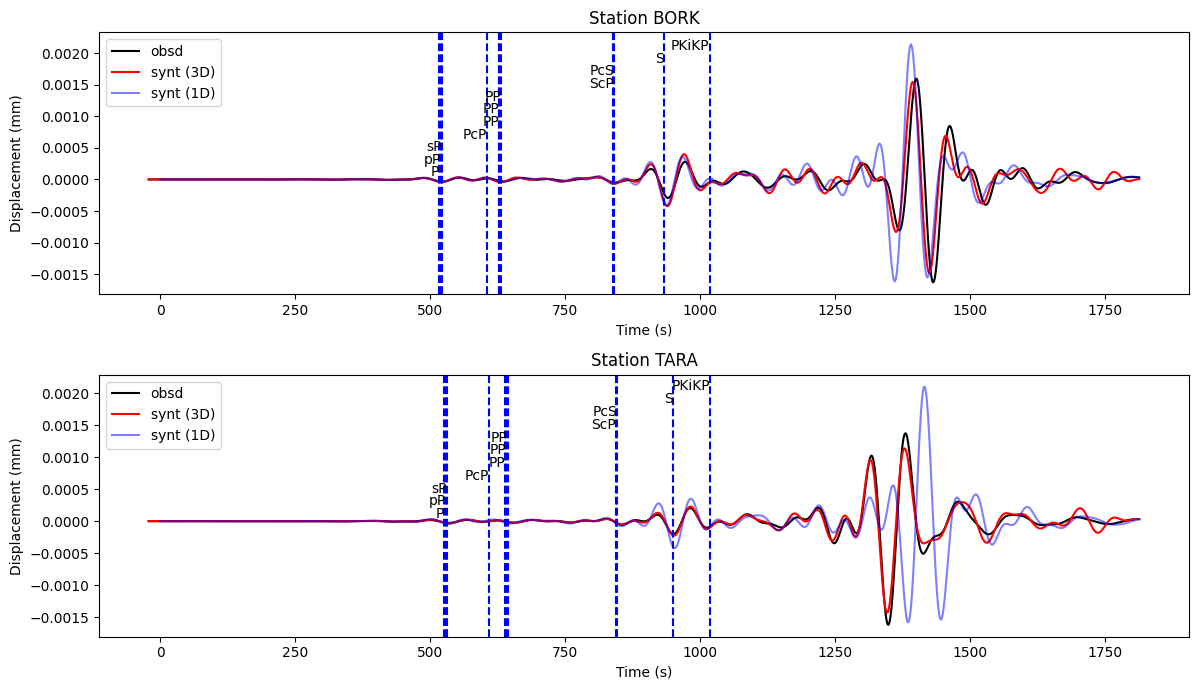

<PolarAxes: >

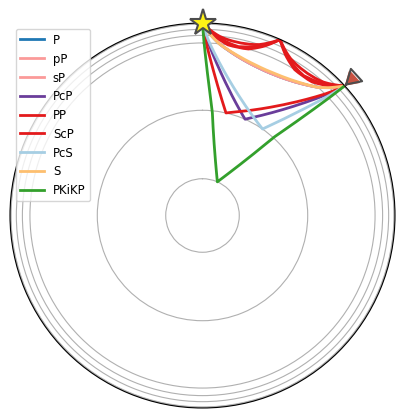

In [16]:
# plot the observed and synthetic data by overlaying them
tr_obs_bork = st_obs.select(station="BORK", channel="*Z")[0]
tr_syn_bork = st_syn.select(station="BORK", channel="*Z")[0]
tr_syn_1d_bork = st_syn_1d.select(station="BORK", channel="*Z")[0]
tr_obs_tara = st_obs.select(station="TARA", channel="*Z")[0]
tr_syn_tara = st_syn.select(station="TARA", channel="*Z")[0]
tr_syn_1d_tara = st_syn_1d.select(station="TARA", channel="*Z")[0]

fig, ax = plt.subplots(2,1 , figsize=(12, 7))
ax[0].plot(tr_obs_bork.times(reftime=reftime),    tr_obs_bork.data, "k", label="obsd")
ax[0].plot(tr_syn_bork.times(reftime=reftime),    tr_syn_bork.data, "r", label="synt (3D)")
ax[0].plot(tr_syn_1d_bork.times(reftime=reftime), tr_syn_1d_bork.data, "b", label="synt (1D)", alpha=0.5)
ax[0].legend(loc=2)
ax[0].set_ylabel("Displacement ({})".format(disp_unit))
ax[0].set_xlabel("Time (s)")
ax[0].set_title("Station BORK")
ax[1].plot(tr_obs_tara.times(reftime=reftime),    tr_obs_tara.data, "k", label="obsd")
ax[1].plot(tr_syn_tara.times(reftime=reftime),    tr_syn_tara.data, "r", label="synt (3D)")
ax[1].plot(tr_syn_1d_tara.times(reftime=reftime), tr_syn_1d_tara.data, "b", label="synt (1D)", alpha=0.5)
ax[1].legend(loc=2)
ax[1].set_ylabel("Displacement ({})".format(disp_unit))
ax[1].set_xlabel("Time (s)")
ax[1].set_title("Station TARA")

# for limitting the x-axis
#ax[0].set_xlim(400, 700)
#ax[1].set_xlim(400, 700)

# add P- and S-wave arrivals
phase_list=["P", "S","pP","sP","PP","PcP","ScP","PcS","PKiKP"]

model = TauPyModel(model="iasp91")
arrivals_bork = model.get_ray_paths(
    source_depth_in_km=origin.depth/1000,
    distance_in_degree=locations2degrees(origin.latitude, origin.longitude,
                                         tr_syn_bork.stats.sac["stla"], tr_syn_bork.stats.sac["stlo"]),
    phase_list=phase_list)
arrivals_tara = model.get_ray_paths(
    source_depth_in_km=origin.depth/1000,
    distance_in_degree=locations2degrees(origin.latitude, origin.longitude,
                                         tr_syn_tara.stats.sac["stla"], tr_syn_tara.stats.sac["stlo"]),
    phase_list=phase_list)

# draw the arrivals
cc=0
for arrival in arrivals_bork:
    if origin.time + arrival.time < tr_syn_bork.stats.endtime:
        ax[0].axvline(arrival.time, color="blue", linestyle="--")
        ax[0].text(arrival.time, cc, arrival.name, va="bottom", ha="right", color="black")
        cc+=0.0002
cc=0
for arrival in arrivals_tara:
    if origin.time + arrival.time < tr_syn_tara.stats.endtime:
        ax[1].axvline(arrival.time, color="blue", linestyle="--")
        ax[1].text(arrival.time, cc, arrival.name, va="bottom", ha="right", color="black")
        cc+=0.0002

plt.tight_layout()
plt.show()

# plot raypath
fig, ax = plt.subplots(subplot_kw=dict(polar=True),figsize=(5,5))

arrivals_bork.plot_rays(plot_type='spherical',
                        label_arrivals=False,
                        legend=True,
                        plot_all=True,
                        show=False,ax=ax)


If you want to see seismograms with different period bands, start from `Comparing observed and synthetic data` cell and change the minimum and maximum periods. 


## Calculate the misfit and adjoint sources

The cells below show how to calculate the misfit and adjoint sources using the observed and synthetic data.
In this example, we use **only the initial 15 minutes** of the seismograms instead of the full length (30 minutes) to reduce the computation time,
which includes the P-wave arrival.


### About the number of time steps in SPECFEM3D_GLOBE

On the output seismograms, the CMT time is used as `t=0`, then the record starts from `t=-half_duration*1.5`.
Then the total record length (NSTEP) is calculated by

``` fortran
! in read_compute_parameters.f90
NSTEP = 100 * (int(RECORD_LENGTH_IN_MINUTES * 60.d0 / (100.d0*DT)) + 1)

! then if CMTSOLUTION is given, add 1.5 times of half duration in setup_sources_receivers.f90
NSTEP = NSTEP + 100 * (int( abs(half_duration*1.5) / (100.d0*DT)) + 1)
```

In [17]:
# cut synthetics to be a half (30 to 15 mins)

# calculate NSTEP for 15 minutes
record_length = 15 # minutes
half_duration = 14.2 # second
dt = st_syn[0].stats.delta

# calculate NSTEP with the same way of SPECFEM3D_GLOBE (read_compute_parameters.f90)
NSTEP = 100 * (int(record_length * 60 / (100*dt)) + 1)
# add half_duration
NSTEP += 100 * (int(half_duration*1.5 / (100*dt)) + 1)

for tr in (st_syn+st_obs):
    tr.trim(tr.stats.starttime, tr.stats.starttime + int(NSTEP-1)*tr.stats.delta, pad=True)

print("New NSTEP: ", NSTEP)

# store the original synthetic trace for a validation purpose
st_syn_orig = st_syn.copy()

New NSTEP:  6700


## Rotation of the 3 components of the seismograms

Before calculating adjoint sources, we usually rotate the 3 components of the seismograms from the East-North-Vetical (ENZ) coordinate system to the **Radial-Transverse-Vertical (RTZ)** coordinate system.  
The cell below shows how to rotate the seismograms from the ENZ to the RTZ coordinate system with obspy functions.
In this example, we only use the vertical component of the seismograms, but we show how the rotation can be performed for a reference.

In [18]:
# perform ENZ to RTZ rotation for the synthetic and observed data

def preprocess_before_adjoint_source_calculation(st,ev,obs_data=True):
    # perform ENZ to RTZ rotation for the synthetic and observed data

    list_st_names = list(set([tr.stats.station for tr in st]))
    for st_name in list_st_names:
        # calculate the back azimuth
        if obs_data:
            # calculate the back azimuth by using the event and station coordinates
            baz = obspy.geodetics.gps2dist_azimuth(ev.origins[0].latitude,ev.origins[0].longitude,
                                                    st.select(station=st_name)[0].stats.latitude,
                                                    st.select(station=st_name)[0].stats.longitude)[2]
        else:
            # synthetic data contains the back azimuth information
            baz = st.select(station=st_name)[0].stats.sac["baz"]

        st.select(station=st_name).rotate(method="NE->RT", back_azimuth=baz)

# rotate the traces
# observed data
preprocess_before_adjoint_source_calculation(st_obs, event, obs_data=True)
# synthetic data
preprocess_before_adjoint_source_calculation(st_syn, event, obs_data=False)

## Definitions of misfit functions and adjoint sources

The equations below are the three different misfit functions and their corresponding adjoint sources used in this example.
The sign of the adjoint source need to be checked very carefully, otherwise the optimization steps will go in the wrong direction.

### Normalized Waveform Misfit:

Misfit function 
$$
\chi(m) = \frac{1}{2} \sum_{i=1}^{N_s} \sum_{j=1}^{N_r} \frac{\int_0^T [d_{ij}(t) - s_{ij}(t,m)]^2 dt}{\int_0^T d_{ij}^2(t) dt} 
$$
Adjoint source for i-th event, j-th station
$$
f_{ij}^\dagger(t) = \frac{-(d_{ij}(t) - s_{ij}(t,m))}{\int_0^T d_{ij}^2(t) dt} 
$$

### Traveltime Misfit:

Misfit function
$$
\chi = \frac{1}{2} \sum_{i=1}^{N_s} \sum_{j=1}^{N_r} [T^{obs}_{ij} - T^{syn}_{ij}]^2
$$
Adjoint source for i-th event, j-th station
$$
f^{\dagger}_{ij}(t) = - \frac{1}{N} ~ \left[ T^{obs}_{ij} - T^{syn}_{ij} \right] ~ 
\partial_t s_{ij}(t,m),
$$

where 
$$
N = \int_0^T ~ s_{ij}(t,m) ~
\partial^2_t s_{ij}(t,m) dt.
$$

In order to avoid the error introduced by the 2nd order derivative, we apply integration by part and use the following formula:
$$
N =\int_0^T ~ \partial_t s_{ij}(t,m) \partial_t s_{ij}(t,m) dt
$$
then the adjoint source becomes
$$
f^{\dagger}_{ij}(t) = \frac{1}{N} ~ \left[ T^{obs}_{ij} - T^{syn}_{ij} \right] ~ 
\partial_t s_{ij}(t,m),
$$


### Amplitude Misfit:

Misfit function
$$
\chi = \frac{1}{2} \sum_{i=1}^{N_s}  \sum_{j=1}^{N_r} \left[ \ln \left( \frac{A^{obs}_{ij}}{A^{syn}_{ij}(m)} \right) \right]^2
$$
Adjoint source for i-th event, j-th station
$$
f^{\dagger}_{ij}(t) = - \frac{1}{M} ~ \left[ \ln \left( \frac{A^{obs}_{ij}}{A^{syn}_{ij}(m)} \right) \right] s_{ij}(t),
$$

where
$$
M = \int_0^T s_{ij}^2(t,m)dt
$$





In [19]:
# available adjoint source types
available_adjtype = ['waveform', 'traveltime', 'amplitude', 'none']

# custom window functions
def window_taper(signal, taper_percentage, taper_type):
    npts = len(signal)
    frac = int(npts * taper_percentage / 2.0 + 0.5)

    idx1 = frac
    idx2 = npts - frac

    if taper_type == "hann":
        window = 0.5 - 0.5 * np.cos(2.0 * np.pi * np.arange(0, 2 * frac) / (2 * frac - 1))
    elif taper_type == "cos":
        window = np.cos(np.pi * np.arange(0, 2 * frac) / (2 * frac - 1) - np.pi / 2.0)
    elif taper_type == "cos_p10":
        window = 1. - np.cos(np.pi * np.arange(0, 2 * frac) / (2 * frac - 1)) ** 10

    signal[:idx1] *= window[:frac]
    signal[idx2:] *= window[frac:]

    # return test signal
    test = np.ones(npts)
    test[:idx1] = window[:frac]
    test[idx2:] = window[frac:]

    return signal, test

# cross-correlation function to calculate the time shift
def xcorr_shift(d, s):
    cc = np.correlate(d, s, mode="full")
    time_shift = cc.argmax() - len(d) + 1
    return time_shift

# function to calculate adjoint source
def calculate_adjoint_source(_tr_obs, _tr_syn, origin, tmin, tmax,
                             plot=False, adjtype='waveform', taper_percentage=0.3, win_type='cos_p10', save_img=False):
    """
    Calculate adjoint source
    tmin and tmax are the window range in seconds for the adjoint source calculation, starting from the first data point of the trace
    """

    if adjtype not in available_adjtype:
        print(f"adjtype {adjtype} is not available. Please choose from {available_adjtype}")
        return None

    # copy the observed and synthetic data
    tr_obs = _tr_obs.copy()
    tr_syn = _tr_syn.copy()

    # event time (CMT time)
    event_time = origin.time

    # window for the adjoint source calculation
    tr_obs.trim(starttime=event_time+tmin, endtime=event_time+tmax)
    tr_syn.trim(starttime=event_time+tmin, endtime=event_time+tmax)
    tr_obs.data, _ = window_taper(tr_obs.data, taper_percentage, win_type)
    tr_syn.data, _ = window_taper(tr_syn.data, taper_percentage, win_type)

    # check if the observed and synthetic data have the same data length and sampling rate
    if tr_obs.stats.npts != tr_syn.stats.npts:
        print(f"Observed and synthetic data have different data length: {tr_obs.stats.npts} and {tr_syn.stats.npts}")
        return None

    if tr_obs.stats.sampling_rate != tr_syn.stats.sampling_rate:
        print(f"Observed and synthetic data have different sampling rate: {tr_obs.stats.sampling_rate} and {tr_syn.stats.sampling_rate}")
        return None

    # calculate adjoint source
    s, e = st_syn_orig[0].stats.starttime, st_syn_orig[0].stats.endtime
    tr_adj_w = tr_syn.copy()
    tr_adj_t = tr_syn.copy()
    tr_adj_a = tr_syn.copy()

    #
    # waveform adjoint source
    #
    # calculate the misfit function
    misfit_w = 0.5*simpson((tr_obs.data - tr_syn.data) ** 2, dx=tr_obs.stats.delta)

    # normalization factor
    norm_w = simpson(tr_obs.data**2, dx=tr_obs.stats.delta)

    # calculate the adjoint source = - factor*(observed - synthetic)
    tr_adj_w.data = - (tr_obs.data - tr_syn.data) / norm_w

    #
    # traveltime adjoint source
    #
    # calculate time shift and amplitude anomaly by cross-correlation
    ishift = xcorr_shift(tr_obs.data, tr_syn.data)
    tshift = ishift * tr_syn.stats.delta

    # misfit function for the time shift and amplitude anomaly
    misfit_t = 0.5 * tshift**2

    # calculate the derivative of the current displacement
    _v = np.gradient(tr_syn.data, tr_syn.stats.delta)

    # normalization factor
    norm_t = simpson(_v**2, dx=tr_syn.stats.delta)

    # calculate traveltime adjoint source
    tr_adj_t.data = tshift * _v / norm_t

    #
    # amplitude adjoint source
    #
    # amplitude ratio
    amp_ratio = np.max(tr_obs.data) / np.max(tr_syn.data)

    # misfit
    misfit_a = 0.5 * (np.log(amp_ratio) ** 2)

    # normalization factor
    norm_a = simpson(tr_syn.data**2, dx=tr_syn.stats.delta)

    # calculate amplitude adjoint source
    tr_adj_a.data = -1.0 * np.log(amp_ratio) * tr_syn.data / norm_a

    # apply the same filter as the synthetic data
    for tr in [tr_adj_w, tr_adj_t, tr_adj_a]:
        tr.detrend("linear")
        tr.detrend("demean")
        tr.taper(0.05, type="cosine")
        sac_taper(tr)
        # taper the adjoint source
        tr.data, wtest = window_taper(tr.data, taper_percentage, win_type)
        # zero padding
        tr.trim(starttime=s, endtime=e, pad=True, fill_value=0.0)

        # check the data compatibility
        if tr.stats.npts != st_syn_orig[0].stats.npts:
            print(f"Adjoint source has different data length: {tr.stats.npts} and synthetic {st_syn_orig[0].stats.npts}")
            return None
        if tr.stats.sampling_rate != st_syn_orig[0].stats.sampling_rate:
            print(f"Adjoint source has different sampling rate: {tr.stats.sampling_rate} and synthetic {st_syn_orig[0].stats.sampling_rate}")
            return None

    if plot:
        # copy traces for plotting
        tr_obs_plot = _tr_obs.copy()
        tr_syn_plot = _tr_syn.copy()

        # mergin for xlimit
        xmin = np.max([(tr_adj_w.times(reftime=event_time)[0]+tmin)*0.8, tr_adj_w.times(reftime=event_time)[0]])
        xmax = np.min([(tr_adj_w.times(reftime=event_time)[0]+tmax)*1.2, tr_adj_w.times(reftime=event_time)[-1]])

        # take max and min of the data in xrange
        vmin = min(tr_obs_plot.data[(tr_obs_plot.times(reftime=event_time) > tmin) & (tr_obs_plot.times(reftime=event_time) < tmax)].min(),
                   tr_syn_plot.data[(tr_syn_plot.times(reftime=event_time) > tmin) & (tr_syn_plot.times(reftime=event_time) < tmax)].min())*1.3
        vmax = max(tr_obs_plot.data[(tr_obs_plot.times(reftime=event_time) > tmin) & (tr_obs_plot.times(reftime=event_time) < tmax)].max(),
                   tr_syn_plot.data[(tr_syn_plot.times(reftime=event_time) > tmin) & (tr_syn_plot.times(reftime=event_time) < tmax)].max())*1.3
        vmin = -1.0 * max(np.abs(vmin), np.abs(vmax))
        vmax = -1.0 * vmin

        # check vmin and vmax between xmin and xmax for entire signal
        vmin_whole = min(tr_obs_plot.data.min(), tr_syn_plot.data.min())*1.3
        vmax_whole = max(tr_obs_plot.data.max(), tr_syn_plot.data.max())*1.3

        # check vmin and vmax between xmin and xmax for adjoint source
        vmin_adj_w = tr_adj_w.data.min()*1.3
        vmax_adj_w = tr_adj_w.data.max()*1.3
        vmin_adj_t = tr_adj_t.data.min()*1.3
        vmax_adj_t = tr_adj_t.data.max()*1.3
        vmin_adj_a = tr_adj_a.data.min()*1.3
        vmax_adj_a = tr_adj_a.data.max()*1.3

        # plot tr_obs and tr_syn on axs[0] (whole signal), axs[1] (around the window), then plot tr_adj on axs[2]
        #fig, axs = plt.subplots(5, 1, figsize=(6, 8), sharex=False)
        fig = plt.figure(figsize=(12, 5))
        ax1 = plt.subplot(3,2,1)
        ax2 = plt.subplot(3,2,2)
        ax3 = plt.subplot(3,2,3)
        ax4 = plt.subplot(3,2,4)
        ax5 = plt.subplot(3,2,5)
        axs = [ax1, ax2, ax3, ax4, ax5]

        axs[0].plot(tr_obs_plot.times(reftime=event_time), tr_obs_plot.data, 'k', label='Observed')
        axs[0].plot(tr_syn_plot.times(reftime=event_time), tr_syn_plot.data, 'r', label='Synthetic')
        axs[0].set_title(f"Station (obs) {tr_obs.stats.station} {tr_obs.stats.channel} - (syn) {tr_syn.stats.station} {tr_syn.stats.channel}")
        axs[0].set_xlabel('Time (s)')
        axs[0].set_ylabel(f'Displacement ({disp_unit})')
        axs[0].legend()

        axs[1].plot(tr_obs_plot.times(reftime=event_time), tr_obs_plot.data, 'k', label='Observed')
        axs[1].plot(tr_syn_plot.times(reftime=event_time), tr_syn_plot.data, 'r', label='Synthetic')
        axs[1].set_title(f"Station (obs) {tr_obs.stats.station} {tr_obs.stats.channel} - (syn) {tr_syn.stats.station} {tr_syn.stats.channel}")
        axs[1].set_xlabel('Time (s)')
        axs[1].set_ylabel(f'Displacement ({disp_unit})')
        #axs[1].legend()

        axs[2].plot(tr_adj_w.times(reftime=event_time), tr_adj_w.data, 'k', label='Adjoint source')
        axs[2].set_title(f"Adjoint source, type: waveform, misfit: {misfit_w:.4e}")
        axs[2].set_xlabel('Time (s)')
        axs[3].plot(tr_adj_t.times(reftime=event_time), tr_adj_t.data, 'k', label='Adjoint source')
        axs[3].set_title(f"Adjoint source, type: traveltime, misfit: {misfit_t:.4e}")
        axs[3].set_xlabel('Time (s)')
        axs[4].plot(tr_adj_a.times(reftime=event_time), tr_adj_a.data, 'k', label='Adjoint source')
        axs[4].set_title(f"Adjoint source, type: amplitude, misfit: {misfit_a:.4e}")
        axs[4].set_xlabel('Time (s)')

        axs[0].set_xlim(tr_adj_w.times(reftime=event_time)[0], tr_adj_w.times(reftime=event_time)[-1])
        axs[1].set_xlim(xmin, xmax)
        axs[2].set_xlim(xmin, xmax)
        axs[3].set_xlim(xmin, xmax)
        axs[4].set_xlim(xmin, xmax)

        axs[1].set_ylim(vmin, vmax)

        # vertical lines for the taper region
        for i in range(5):
            axs[i].axvline(tmin, color='grey', linestyle='--')
            axs[i].axvline(tmax, color='grey', linestyle='--', label='Taper region')

        # change background color for the taper region with wtest_obs value
        x, y = np.meshgrid(np.linspace(tmin,tmax,100), np.linspace(vmin, vmax,100))
        for i in range(5):
            if i == 0:
                extent = [tmin, tmax, vmin_whole, vmax_whole]
            elif i == 1:
                extent = [tmin, tmax, vmin, vmax]
            elif i == 2:
                extent = [tmin, tmax, vmin_adj_w, vmax_adj_w]
            elif i == 3:
                extent = [tmin, tmax, vmin_adj_t, vmax_adj_t]
            elif i == 4:
                extent = [tmin, tmax, vmin_adj_a, vmax_adj_a]
            # z from wtime_obs
            axs[i].imshow(wtest.reshape(1,-1), extent=extent, aspect='auto', cmap='Greys', alpha=0.3)

        # plot arrival time
        if tr_adj_t.stats.station == "BORK":
            arrivals = arrivals_bork
        elif tr_adj_t.stats.station == "TARA":
            arrivals = arrivals_tara

        if trace.stats.station in ["BORK", "TARA"]:
            cc=0
            for arrival in arrivals:
                if arrival.time < xmax and arrival.time > xmin:
                    axs[1].axvline(arrival.time, color="blue", linestyle="--")
                    axs[1].text(arrival.time, (cc%3)*vmax*0.3, arrival.name, va="bottom", ha="right", color="black")
                    cc+=1


        plt.tight_layout()

        if save_img:
            plt.savefig(f"./adjoint_source_{tr_adj_t.stats.station}.png")

        plt.show();

    if adjtype == 'waveform':
        return tr_adj_w, misfit_w
    elif adjtype == 'traveltime':
        return tr_adj_t, misfit_t
    elif adjtype == 'amplitude':
        return tr_adj_a, misfit_a
    else:
        pass


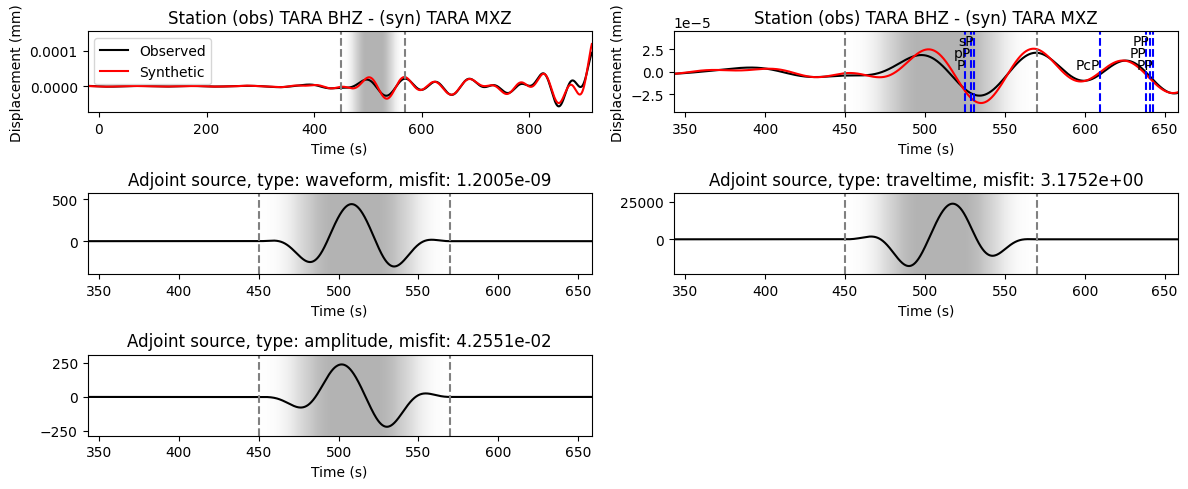

In [ ]:
%matplotlib inline

# for TARA station
test_tr_syn = st_syn.select(station='TARA', channel='MXZ')[0].copy()
test_tr_obs = st_obs.select(station='TARA', channel='BHZ')[0].copy()

twin_TARA = [450, 570]
taper_percentage_TARA=0.8 # window length * taper_percentage / 2 is the taper length of the initial and final part of the window
win_type='hann'


if interactive is False:
    _, _ = calculate_adjoint_source(test_tr_obs, test_tr_syn, origin, twin_TARA[0], twin_TARA[1], plot=True, adjtype='waveform',
                                    taper_percentage=taper_percentage_TARA, win_type=win_type, save_img=True)
else:
    itp = interactive(calculate_adjoint_source, _tr_obs=fixed(test_tr_obs), _tr_syn=fixed(test_tr_syn), origin=fixed(origin),
                tmin=IntSlider(min=0, max=test_tr_syn.times(reftime=reftime)[-1], step=1, value=450, description='tmin', continuous_update=False, layout=Layout(width='50%')),
                tmax=IntSlider(min=0, max=test_tr_syn.times(reftime=reftime)[-1], step=1, value=570, description='tmax', continuous_update=False, layout=Layout(width='50%')),
                adjtype=fixed('none'),
                plot=fixed(True),
                taper_percentage=FloatSlider(min=0.0, max=1.0, step=0.1, value=0.8, description='taper_percentage', continuous_update=False),
                win_type=Dropdown(options=['hann', 'cos', 'cos_p10'], value='hann', description='win_type'),
                save_img=fixed(True))

    display(itp)


In [26]:
if interactive:
    # store the current parameters for the adjoint source calculation
    twin_TARA = [itp.kwargs["tmin"], itp.kwargs["tmax"]]
    taper_percentage_TARA = itp.kwargs["taper_percentage"]
    win_type_TARA = itp.kwargs["win_type"]
else:
    # store the current parameters for the adjoint source calculation
    win_type_TARA = win_type

print("parameters for TARA station:")
print(f"twin: {twin_TARA}")
print(f"taper_percentage: {taper_percentage_TARA}")
print(f"win_type: {win_type_TARA}")

parameters for TARA station:
twin: [450, 570]
taper_percentage: 0.8
win_type: hann


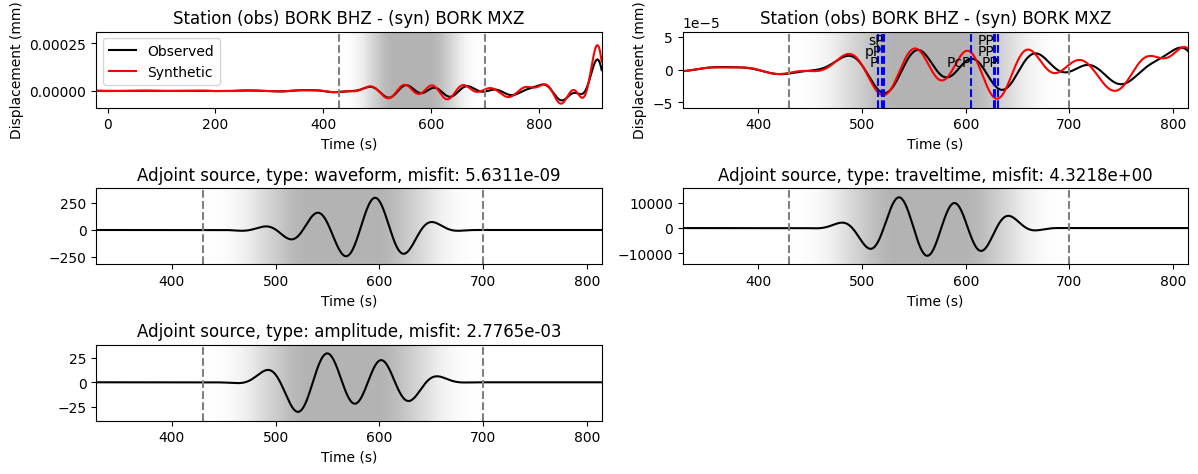

In [ ]:
%matplotlib inline

# calculate adjoint source for 'BORK' station
test_tr_syn = st_syn.select(station='BORK', channel='MXZ')[0].copy()
test_tr_obs = st_obs.select(station='BORK', channel='BHZ')[0].copy()

twin_BORK = [430, 700] # include other phases
#twin_BORK = [430, 550] # only P-wave
taper_percentage_BORK=0.8 # window length * taper_percentage / 2 is the taper length of the initial and final part of the window
win_type='hann'

if interactive is False:
    _, _ = calculate_adjoint_source(test_tr_obs, test_tr_syn, origin, twin_BORK[0], twin_BORK[1], plot=True, adjtype='waveform',
                                    taper_percentage=taper_percentage_BORK, win_type=win_type, save_img=True)
else:
    itp = interactive(calculate_adjoint_source, _tr_obs=fixed(test_tr_obs), _tr_syn=fixed(test_tr_syn), origin=fixed(origin),
                tmin=IntSlider(min=0, max=test_tr_syn.times(reftime=reftime)[-1], step=1, value=430, description='tmin', continuous_update=False, layout=Layout(width='50%')),
                tmax=IntSlider(min=0, max=test_tr_syn.times(reftime=reftime)[-1], step=1, value=700, description='tmax', continuous_update=False, layout=Layout(width='50%')),
                adjtype=fixed('none'),
                plot=fixed(True),
                taper_percentage=FloatSlider(min=0.0, max=1.0, step=0.1, value=0.8, description='taper_percentage', continuous_update=False),
                win_type=Dropdown(options=['hann', 'cos', 'cos_p10'], value='hann', description='win_type'),
                save_img=fixed(True))

    display(itp)

In [28]:
if interactive:

    # store the current parameters for the adjoint source calculation
    twin_BORK = [itp.kwargs["tmin"], itp.kwargs["tmax"]]
    taper_percentage_BORK = itp.kwargs["taper_percentage"]
    win_type_BORK = itp.kwargs["win_type"]
else:
    # store the current parameters for the adjoint source calculation
    win_type_BORK = win_type

print("parameters for BORK station:")
print(f"twin: {twin_BORK}")
print(f"taper_percentage: {taper_percentage_BORK}")
print(f"win_type: {win_type_BORK}")

parameters for BORK station:
twin: [430, 700]
taper_percentage: 0.8
win_type: hann


In [29]:
channel_list = ['*Z', '*R', '*T'] # BHZ, BHR, BHT in the observed data and MXZ, MXR, MXT in the synthetic data

def calculate_adjoint_source_all_components(st_obs, st_syn, origin, tmin, tmax, plot=False, adjtype='traveltime',
                                            taper_percentage=0.6, win_type='hann',ch='all'):
    """
    Calculate adjoint source for all the three components
    """

    # initialize adjoint source
    st_adj = obspy.Stream()

    # calculate adjoint source for each component
    if ch=='all':
        for channel in channel_list:
            tr_obs = st_obs.select(channel=channel)[0]
            tr_syn = st_syn.select(channel=channel)[0]

            tr_adj, misfit = calculate_adjoint_source(tr_obs, tr_syn, origin, tmin, tmax, plot=plot, adjtype=adjtype,
                                                      taper_percentage=taper_percentage, win_type=win_type)

            # append the adjoint source to the stream
            st_adj += tr_adj
    elif ch not in channel_list:
         print("Error: Channel not in list")
    else:
        for channel in channel_list:
            if channel==ch:
                print ("calculating ch ", channel)
                tr_obs = st_obs.select(channel=channel)[0]
                tr_syn = st_syn.select(channel=channel)[0]

                tr_adj, misfit = calculate_adjoint_source(tr_obs, tr_syn, origin, tmin, tmax, plot=plot, adjtype=adjtype,
                                                              taper_percentage=taper_percentage, win_type=win_type)
                st_adj+=tr_adj

            else:
                print("zero trace for channel ", channel)
                tr_syn = st_syn.select(channel=channel)[0]
                tr_adj = tr_syn.copy()
                tr_adj.data = np.zeros(len(tr_adj.data))
                st_adj+=tr_adj

    return st_adj

In [30]:
# prepare the adjoint source for all the stations/components

# BORK station
st_obs_bork = st_obs.select(station='BORK').copy()
st_syn_bork = st_syn.select(station='BORK').copy()
st_adj_bork = calculate_adjoint_source_all_components(st_obs_bork, st_syn_bork, origin, twin_BORK[0], twin_BORK[1],
                                                      plot=False, adjtype='traveltime', taper_percentage=taper_percentage_BORK,
                                                      win_type=win_type_BORK, ch='*Z')
# rotate the adjoint source back to ENZ
st_adj_bork.rotate('RT->NE')

# TARA station
st_obs_tara = st_obs.select(station='TARA').copy()
st_syn_tara = st_syn.select(station='TARA').copy()
st_adj_tara = calculate_adjoint_source_all_components(st_obs_tara, st_syn_tara, origin, twin_TARA[0], twin_TARA[1],
                                                      plot=False, adjtype='traveltime', taper_percentage=taper_percentage_TARA,
                                                      win_type=win_type_TARA, ch='*Z')
# rotate the adjoint source back to ENZ
st_adj_tara.rotate('RT->NE')

pass

calculating ch  *Z
zero trace for channel  *R
zero trace for channel  *T
calculating ch  *Z
zero trace for channel  *R
zero trace for channel  *T


## Prepare the input files for the adjoint source simulation

Below is the file structure for the adjoint simulation. We need to create STATIONS_ADJOINT file and adjoint source files (in SEM directory).

``` text
simulation
├─ DATA
|  ├─ ...
|  ├─ STATIONS_ADJOINT
|
├─ SEM
|  ├─ {network_name}.{station_name}.{component}.adj  (ASCII format)
|
├─ DATABASES_MPI
|  ├─ (no change)
|
├─ OUTPUT_FILES
|  ├─ (no change)

```


## Modify the Par_file for the adjoint simulation

Before starting the adjoint simulation, we need to modify the Par_file for the adjoint simulation as follows:

``` text
# forward or adjoint simulation
SIMULATION_TYPE                 = 1   # set to 1 for forward simulations, 2 for adjoint simulations for sources, and 3 for kernel simulations
NOISE_TOMOGRAPHY                = 0   # flag of noise tomography, three steps (1,2,3). If earthquake simulation, set it to 0.
SAVE_FORWARD                    = .true.   # save last frame of forward simulation or not

```

to 

``` text
# forward or adjoint simulation
SIMULATION_TYPE                 = 3   # set to 1 for forward simulations, 2 for adjoint simulations for sources, and 3 for kernel simulations
NOISE_TOMOGRAPHY                = 0   # flag of noise tomography, three steps (1,2,3). If earthquake simulation, set it to 0.
SAVE_FORWARD                    = .false.   # save last frame of forward simulation or not
```

We do this modification using `change_simulation_type.pl` script in the `utils` directory. (not necessary to do it manually)



In [31]:
# Prepare STATIONS_ADJOINT file

# filename
fname = os.path.join('simulation','DATA', 'STATIONS_ADJOINT')
# combine the adjoint source for BORK and TARA
st_adj = st_adj_bork + st_adj_tara

# prepare the lines for the STATIONS_ADJOINT file
lines = []
for tr in st_adj:
    if tr.stats.channel == 'MXZ':
        line = f"{tr.stats.station} {tr.stats.network} {tr.stats.sac['stla']} {tr.stats.sac['stlo']} {tr.stats.sac['stel']} 0.0\n"
        lines.append(line)

# write out the STATIONS_ADJOINT file
with open(fname, 'w') as f:
    f.writelines(lines)

In [32]:
# write out the adjoint source data
# which requires Time and Amplitude columns
# but actually only the Amplitude column is read by SPECFEM3D_GLOBE/src/compute_arrays_source.f90

# create SEM directory if not exist
os.makedirs(os.path.join('simulation', 'SEM'), exist_ok=True)

for tr in st_adj:
    filename = os.path.join('simulation', 'SEM', f'{tr.stats.network}.{tr.stats.station}.{tr.stats.channel}.adj')
    t = tr.times()
    a = tr.data

    np.savetxt(filename, np.vstack((t, a)).T, fmt='%e', delimiter=' ')


## Running the Adjoint Simulation

In [34]:
# run adjoint simulation with docker
# This will take for ~ 3 hours with 4 mpi processes


# change the directory to the simulation directory
%cd {cwd}/simulation

# change the simulation length to 15 minutes
!sed -i 's/RECORD_LENGTH_IN_MINUTES\s*=.*$/RECORD_LENGTH_IN_MINUTES = 15.0d0/' DATA/Par_file

# change the simulation setup for an adjoint simulation
!{SPECDIR}/utils/change_simulation_type.pl -b

# run the adjoint simulation
!echo "Running adjoint simulation"
!mpirun -np 4 {SPECDIR}/bin/xspecfem3D

# change the directory back to the original directory
%cd ..

/home/mnagaso/workspace/MINES/workshop_scoped_2024_specfem3d_globe/simulation
Changed simulation_type to 3 in Par_file 
Running adjoint simulation
/home/mnagaso/workspace/MINES/workshop_scoped_2024_specfem3d_globe


## Recompose the output file for visualization

The volumetric output data is stored in multiple files in specfem's format. We need to combine and convert the data format to a convenient one for visualization.

For example, to create a recomposed volume data for alpha kernel, run the command below on a running visualization job.

In [35]:
%cd {cwd}/simulation

# run the executable for post processing
!{SPECDIR}/bin/xcombine_vol_data_vtu all alpha_kernel DATABASES_MPI/ DATABASES_MPI/ OUTPUT_FILES/ 1 1

%cd {cwd}

/home/mnagaso/workspace/MINES/workshop_scoped_2024_specfem3d_globe/simulation
 combine volumetric data
   mesh topology dir : DATABASES_MPI/
   input file    dir : DATABASES_MPI/
   variable name     : alpha_kernel

   output directory  : OUTPUT_FILES/
   using VTU format for file output
 mesh parameters (from input directory):
   NSPEC_CRUST_MANTLE =        19440
   NSPEC_OUTER_CORE   =         1548
   NSPEC_INNER_CORE   =           72


 slice list: 
           0           1           2           3

 regions: start =           1  to end =           1

 using mesh with: high resolution

 ----------- Region            1 ----------------
 Reading slice            0
 nglob / nspec =      1285213  /        19440
 Reading slice            1
 nglob / nspec =      1285213  /        19440
 Reading slice            2
 nglob / nspec =      1285213  /        19440
 Reading slice            3
 nglob / nspec =      1285213  /        19440

 VTK initial total points:      5140852
 VTK initial total

### Visualization of the kernel data with ParaView

The created kernel data can be visualized using the [ParaView](https://www.paraview.org/). 

You can download the pre-calculated data from [the google drive here](https://drive.google.com/drive/folders/1PxRvBAS9zUD3aZtw_3goVNDzMv0KFpoo?usp=sharing).

Please replace the `simulation` directory in `workshop_scoped_2024_specfem3d_globe` with the downloaded `simulation` directory.

Then the command below can create the kernel image by running the command below on the terminal:
``` bash
paraview plot_kernel_slices_frontera.pvsm
```

If you have a problem for loading the state file, you can create the slices by running the command below:
```bash
cd ./simulation
pvpython ../create_slice.py OUTPUT_FILES OUTPUT_FILES/reg_1_alpha_kernel.vtu -1
```

This will load the ParaView's state file `plot_kernel_slices_frontera.pvsm` and open the intersections of the alpha kernel. This state file reads the files listed below:

``` text
- simulation/OUTPUT_FILES/reg_1_alpha_kernel.vtu (alpha kernel)
- simulation/OUTPUT_FILES/source.vtk (source location)
- simulation/OUTPUT_FILES/receiver.vtk (receiver locations)
- AVS_boundaries_elliptical.inp (coastlines)
```

Below is the intersection of the alpha kernel which is calculated with this example. As we can see, the kernel for BORK station (right) is much more complex than the kernel for TARA station (left).

<img src="./img/kernel.png" alt="alpha kernel" width="600"/>

The adjoint source used for this kernel is shown below.

<img src="./img/adj_bork_wide.png" alt="adjoint source wide" width="600"/>

If we use the shorter time window for BORK station, the kernel will be simpler as shown below.

<img src="./img/kernel_simple.png" alt="alpha kernel simple" width="600"/>

The adjoint source used for this kernel is shown below.

<img src="./img/adj_bork_short.png" alt="adjoint source short" width="600"/>



## Raypaths plotted on S40RTS model

<img src="./img/s40rts_path.png" alt="raypaths" width=600>

Made using SeisTomoPy (Durand S., R. Abreu, C. Thomas, 2017, SeisTomoPy: Fast visualization, comparison and calculations in global tomographic models, Seis. Res. Lett., 89(2A), 658-667)